## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


Прочитаем наш файл с исходными данными:

In [72]:
taxi_data = pd.read_csv("/kaggle/input/nyc-taxi/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Временные признаки
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [73]:
# ваш код здесь
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [74]:
taxi_data['pickup_datetime'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

### Пропуски
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [75]:
# ваш код здесь
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Статистические характеристики
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [76]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [77]:
taxi_data['dropoff_datetime'].value_counts() 

2016-02-19 19:25:04    5
2016-05-16 19:40:28    5
2016-02-25 20:43:05    4
2016-05-03 18:27:19    4
2016-04-30 21:37:42    4
                      ..
2016-01-21 03:08:16    1
2016-06-29 21:33:16    1
2016-03-15 22:46:27    1
2016-05-25 11:21:56    1
2016-04-05 14:47:43    1
Name: dropoff_datetime, Length: 1380377, dtype: int64

In [78]:
# ваш код здесь
taxi_data['trip_duration'].median()

662.0

In [79]:
print(' минимальное время поездки:', round(taxi_data['trip_duration'].min(),0), 'c.,', 'максимальное время поездки:', round(taxi_data['trip_duration'].max(),0), 'c.') 

 минимальное время поездки: 1 c., максимальное время поездки: 3526282 c.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Форматирования дат
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [80]:
# ваш код здесь
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data   

In [81]:
taxi_data = add_datetime_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


In [82]:
round(len(taxi_data['pickup_date'])/len(taxi_data['pickup_date'].value_counts()),0)

8015.0

### Новые признаки поездок в праздничные дни
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [83]:
holiday_data = pd.read_csv('/kaggle/input/holiday/holiday_data.csv', sep=';')
# ваш код здесь

In [84]:
def add_holiday_features(taxi_df, holiday_df):
    holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%Y-%m-%d')
    taxi_df['pickup_date'] = pd.to_datetime(taxi_df['pickup_date'], format='%Y-%m-%d')
    merge_df = taxi_df.join(holiday_df.set_index('date'), on='pickup_date', how='left')
    merge_df = merge_df.rename(columns={"holiday": "pickup_holiday"})
    merge_df = merge_df.drop(['day'], axis=1)
    merge_df["pickup_holiday"] = merge_df["pickup_holiday"].fillna(0)
    merge_df["pickup_holiday"] = merge_df["pickup_holiday"].apply(lambda x: 1 if x !=0 else x)
   
    return merge_df

In [85]:
taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0


In [86]:
df_new = taxi_data[taxi_data['pickup_holiday'] == 1]
df_median = df_new['trip_duration'].median()
print(f'Медианная длительность поездки на такси в праздничные дни {df_median} c.')

Медианная длительность поездки на такси в праздничные дни 585.0 c.


### Новые признаки OSRM API
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [87]:
osrm_data = pd.read_csv('/kaggle/input/osrmdatatrain/osrm_data_train.csv')
# ваш код здесь
def add_osrm_features(taxi_df, osrm_df):

    geo_df = taxi_df.join(osrm_df.set_index('id')[['total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left') #Объединим DataFrames
 
    return geo_df

In [88]:
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0


In [89]:
median_orsm = taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()
print(f'Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки {round(median_orsm, 0)} c.')

Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки 372.0 c.


In [90]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Расстояние Хваерсина
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [91]:
# ваш код здесь
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'], 
                                                        data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'], 
                                            data['dropoff_latitude'], data['dropoff_longitude'])
    return data

In [92]:
taxi_data = add_geographical_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585


In [93]:
taxi_data['haversine_distance'].median()

2.0937171329263693

### Географический кластер
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [94]:
def add_cluster_features(taxi_df):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    return taxi_df

In [95]:
taxi_data = add_cluster_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9


### Новые признаки погодных условий
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [96]:
weather_data = pd.read_csv('/kaggle/input/weatherdata/weather_data.csv')

def add_weather_features(taxi_df, weather_df):
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    weather_df['hour'] = weather_df['time'].dt.hour
    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]
    taxi_df = taxi_df.merge(
        weather_df[weather_columns], 
        left_on=['pickup_date', 'pickup_hour'], 
        right_on=['date', 'hour'],
        how='left'
    ) 
    taxi_df = taxi_df.drop(['date', 'hour'], axis=1)
    return taxi_df

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


In [97]:
taxi_data.isnull().sum()

id                        0
vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
store_and_fwd_flag        0
trip_duration             0
pickup_date               0
pickup_hour               0
pickup_day_of_week        0
pickup_holiday            0
total_distance            1
total_travel_time         1
number_of_steps           1
haversine_distance        0
direction                 0
geo_cluster               0
temperature           12032
visibility            12032
wind speed            12032
precip                12032
events                12032
dtype: int64

### Заполнение пропусков
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [98]:
def fill_null_weather_data(taxi_df):
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    taxi_df[col] = taxi_df[col].fillna(taxi_df.groupby('pickup_date')[col].transform('median'))
    taxi_df['events'] = taxi_df['events'].fillna('None')
    taxi_df['total_distance'] = taxi_df['total_distance'].fillna(taxi_df['total_distance'].median(skipna=True))
    taxi_df['total_travel_time'] = taxi_df['total_travel_time'].fillna(taxi_df['total_travel_time'].median(skipna=True))
    taxi_df['number_of_steps'] = taxi_df['number_of_steps'].fillna(taxi_df['number_of_steps'].median(skipna=True))
    return taxi_df

In [99]:
taxi_data = fill_null_weather_data(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


In [100]:
temp = taxi_data['temperature'].median()
temp

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


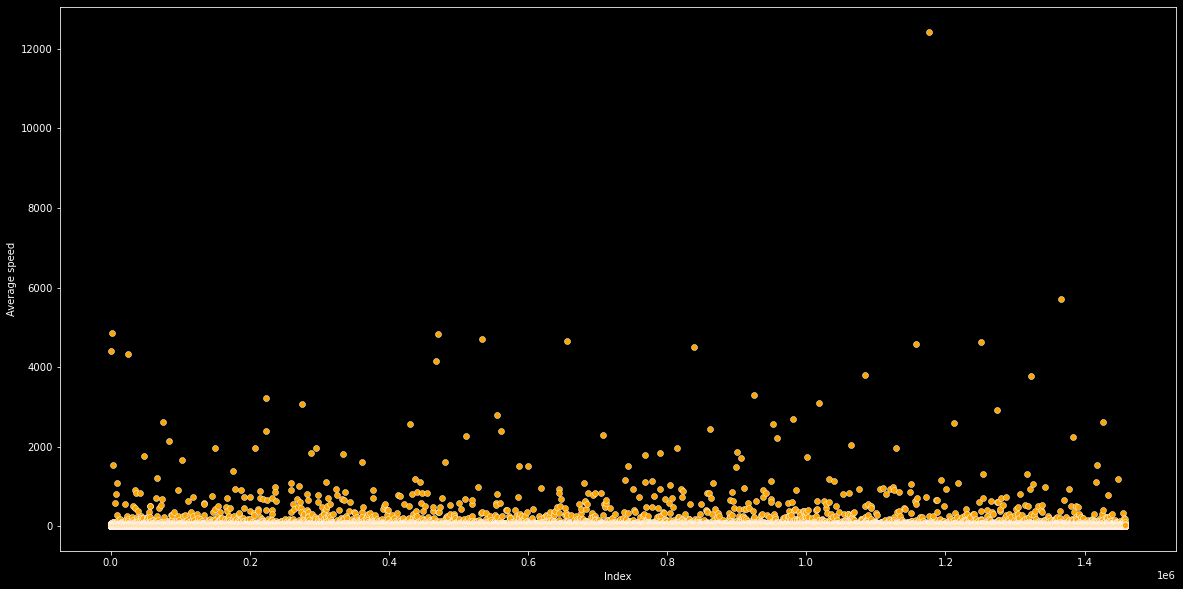

In [101]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax, color='orange')
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Поиск выбросов
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [102]:
tr_dur = taxi_data[(taxi_data['trip_duration'] > 86400)]
print(f'Выбросы по длительности поездки более 24 часа: {tr_dur.shape[0]}')

Выбросы по длительности поездки более 24 часа: 4


In [103]:
speed = taxi_data[((taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) >=300)]
print(f'Выбросы по скорости поездки: {speed.shape[0]}')

Выбросы по скорости поездки: 407


In [104]:
taxi_data = taxi_data.drop(tr_dur.index, axis=0)
taxi_data = taxi_data.drop(speed.index, axis=0)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [105]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Гистограмма и коробчатая диаграмма длительности поездок в логарифмическом масштабе
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


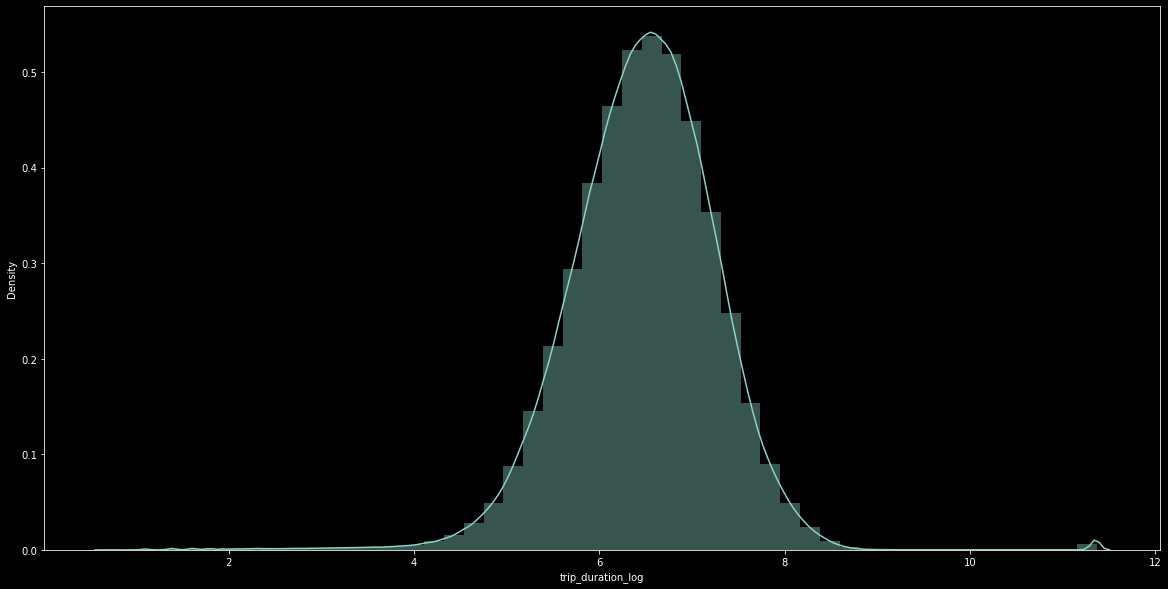

In [106]:
# ваш код здесь
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns_plot = sns.distplot(taxi_data['trip_duration_log'])
fig = sns_plot.get_figure()

In [107]:
stat, p = stats.normaltest(taxi_data['trip_duration_log'])
alpha = 0.05
print('p-value = ', p)
if p < alpha:  # проверка условия
    print("Данные не распределены нормально (мы отвергаем H0)")
else:
    print("Данные распределены нормально")

p-value =  0.0
Данные не распределены нормально (мы отвергаем H0)


### Распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

In [108]:
taxi_data['vendor_id'].value_counts()

2    780118
1    678115
Name: vendor_id, dtype: int64

Text(0.5, 1.0, 'Второй технопарк')

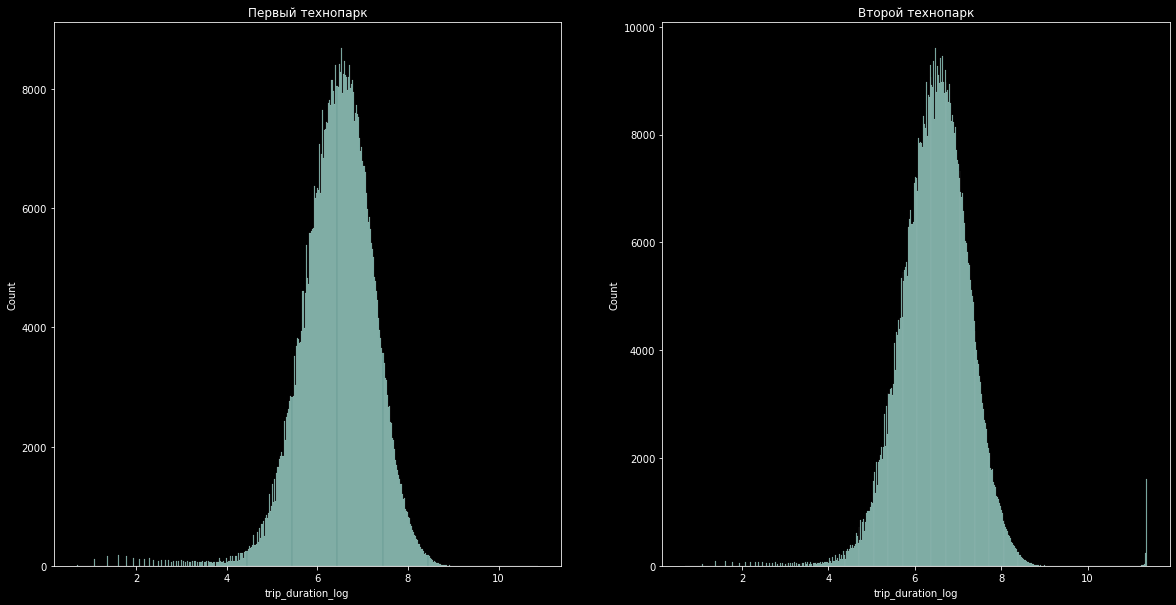

In [109]:
# ваш код здесь
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
histplot  = sns.histplot(data = taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log'], ax=axes[0])
histplot.set_title('Первый технопарк')
histplot  = sns.histplot(data = taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log'], ax=axes[1])
histplot.set_title('Второй технопарк')

### Сравнение распределение поездки от признаки отправки сообщения
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

Text(0.5, 1.0, 'Отправки сообщения поставщику Y')

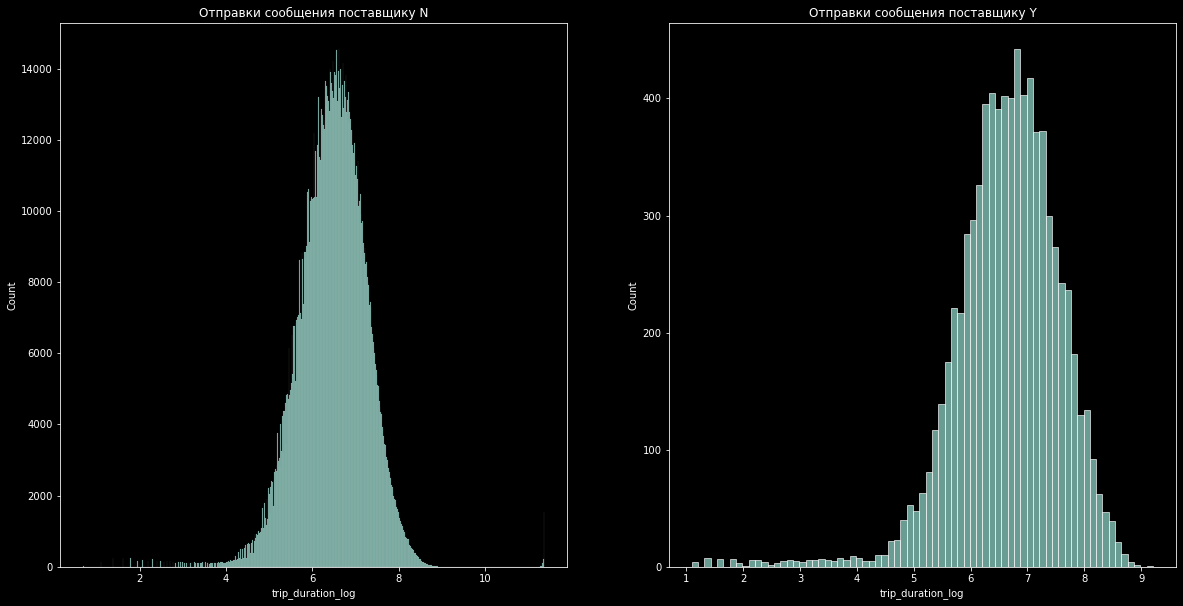

In [110]:
# ваш код здесь
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
histplot  = sns.histplot(data = taxi_data[taxi_data['store_and_fwd_flag'] == 'N']['trip_duration_log'], ax=axes[0])
histplot.set_title('Отправки сообщения поставщику N')
histplot  = sns.histplot(data = taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']['trip_duration_log'], ax=axes[1])
histplot.set_title('Отправки сообщения поставщику Y')

### Распределение количества поездок в зависимости от часа дня
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [111]:
data_1 = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].count()
data_2 = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].median()

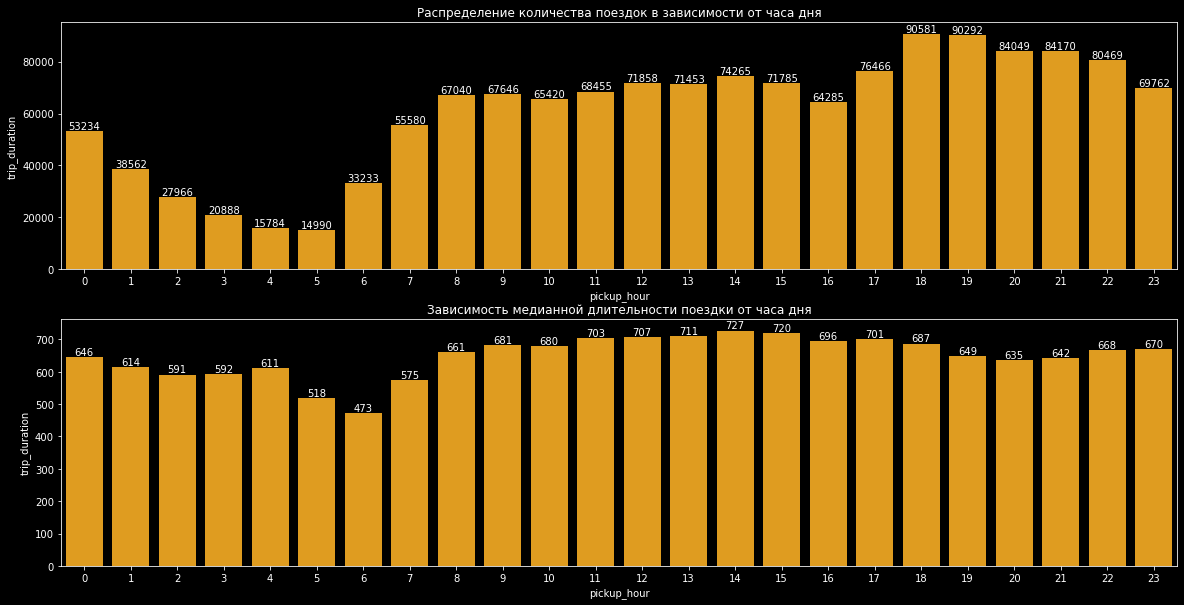

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
barplot = sns.barplot(
    data=data_1,
    x=data_1.iloc[:, 0],
    y=data_1.iloc[:, 1],
    color='orange',
    ax=axes[0]);
barplot.set_title('Распределение количества поездок в зависимости от часа дня');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data_2,
    x=data_2.iloc[:, 0],
    y=data_2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от часа дня');
barplot.bar_label(barplot.containers[0]);

Вывод:
- меньше всего заказывают в 5 часов утра
- пик медианы наблюдается в 14 часов дня

### Распределение количества поездок в зависимости от дня недели
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [113]:
data_3 = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].count()
data_4 = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()

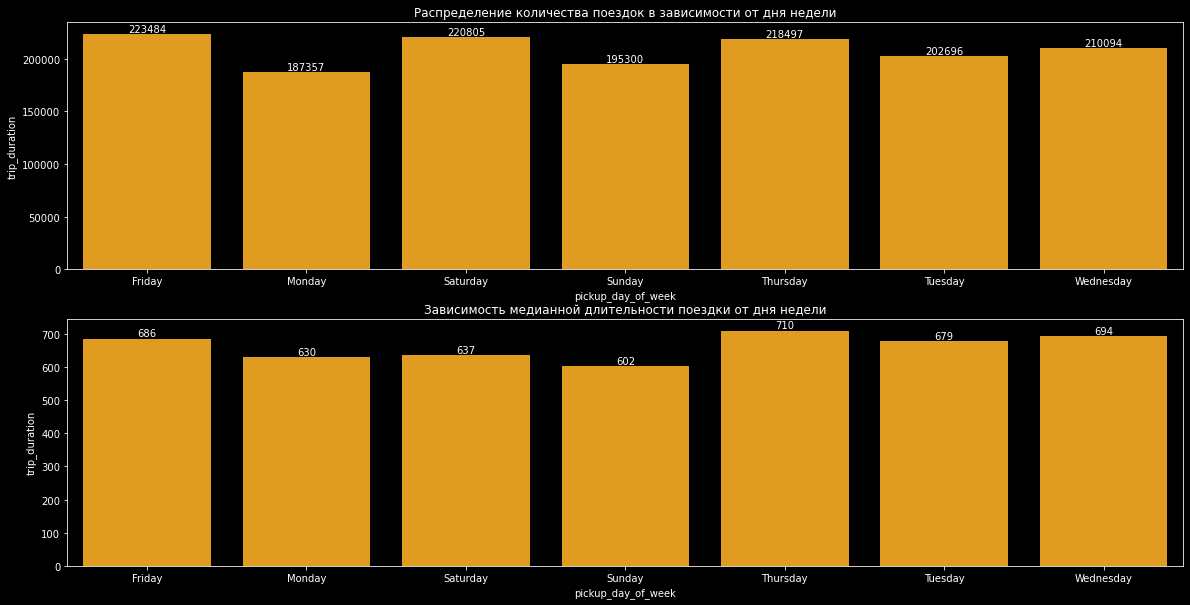

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
barplot = sns.barplot(
    data=data_3,
    x=data_3.iloc[:, 0],
    y=data_3.iloc[:, 1],
    color='orange',
    ax=axes[0]);
barplot.set_title('Распределение количества поездок в зависимости от дня недели');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data_4,
    x=data_4.iloc[:, 0],
    y=data_4.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от дня недели');
barplot.bar_label(barplot.containers[0]);

Вывод:
- больше всего поездок совершают в Пятницу
- наименьшая медианная длительность поездок в воскресенье

### Сводная таблица и тепловая карта зависимости часа дня и дни недели
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [115]:
pivot = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    fill_value=0,
    aggfunc='median'
)
pivot

pickup_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
pickup_hour,,,,,,,
0,649.0,598,685.0,675.0,609,591.0,601.0
1,600.0,567,640.0,643.0,564,584.0,553.0
2,572.0,565,610.0,604.5,576,565.0,544.0
3,578.0,600,591.0,608.0,584,568.0,574.0
4,634.0,640,610.0,598.5,595,600.5,616.0
5,532.0,519,631.0,634.0,480,455.0,448.0
6,476.0,462,508.0,554.0,471,461.0,463.0
7,578.0,575,481.0,474.0,599,586.0,593.0
8,689.0,672,489.0,460.0,721,703.0,704.0


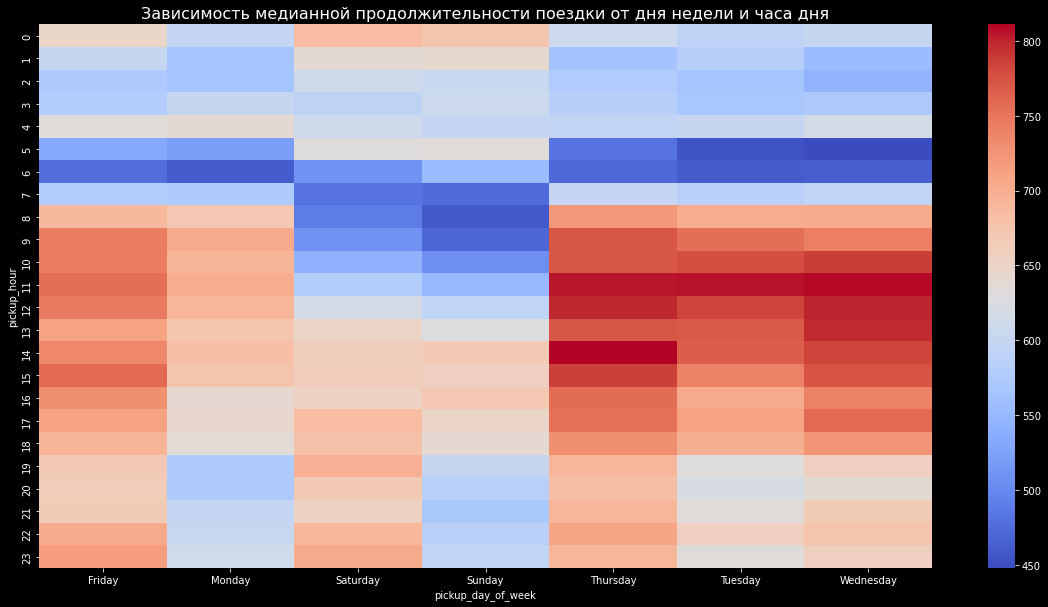

In [116]:
fig, axes = plt.subplots(figsize=(20, 10))
pivot_time = sns.heatmap(data=pivot, cmap="coolwarm");
pivot_time.set_title('Зависимость медианной продолжительности поездки от дня недели и часа дня', fontsize=16);

### Географическое расположение точек начала и конец поездок
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


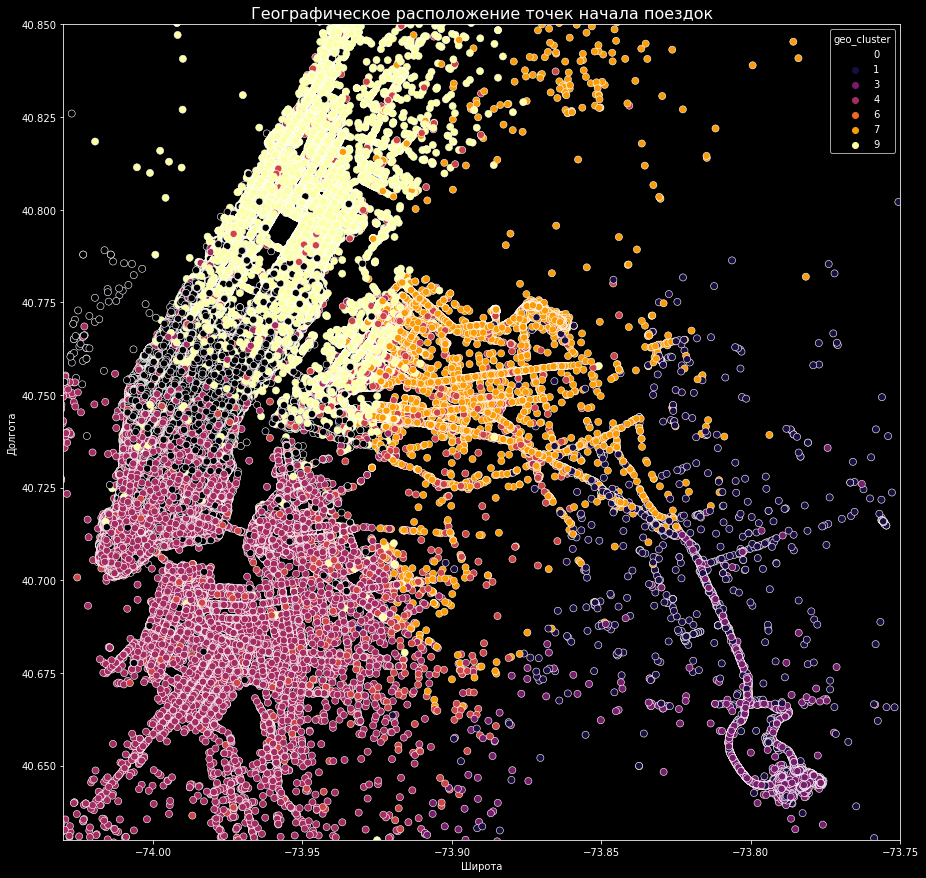

In [117]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot1 = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot1.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot1.set_title('Географическое расположение точек начала поездок', fontsize=16);
scatterplot1.set_xlabel('Широта');
scatterplot1.set_ylabel('Долгота');

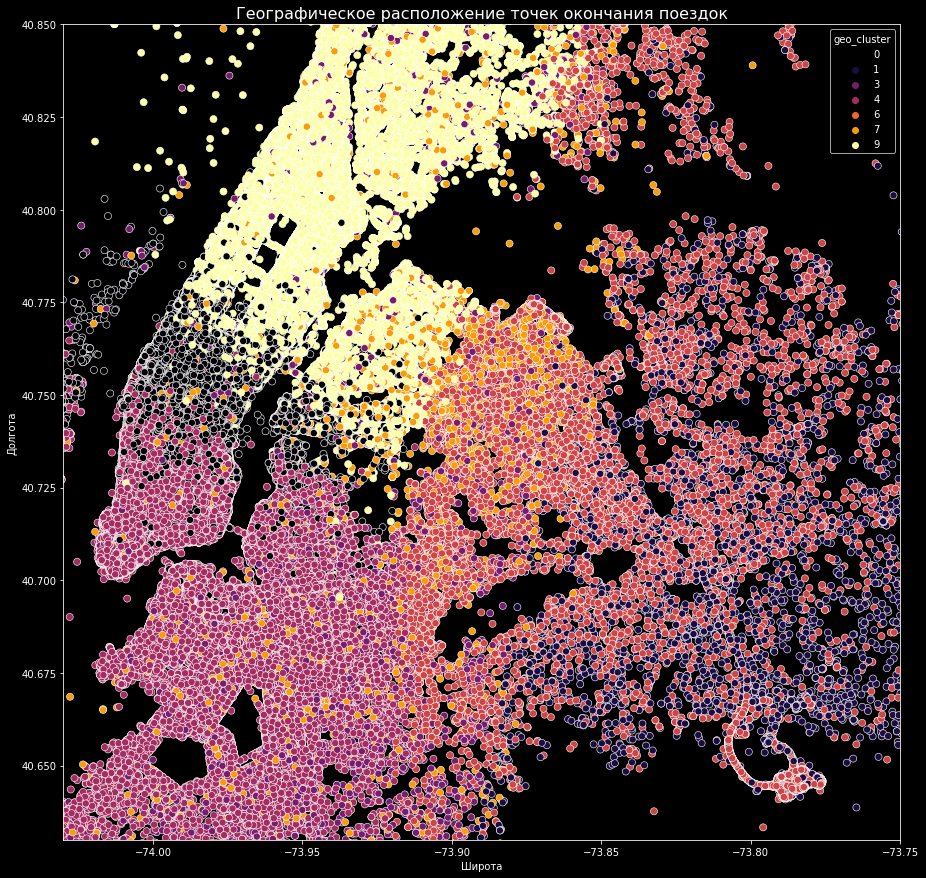

In [118]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot2 = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot2.set_title('Географическое расположение точек окончания поездок', fontsize=16);
scatterplot2.set_xlabel('Широта');
scatterplot2.set_ylabel('Долгота');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [119]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [120]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Неинформативные и избыточные признаки
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [121]:
drop_columns = ['pickup_datetime', 'pickup_date', 'id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Кодировка признака vendor_id
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [122]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
print(f'Среднее по закодированному столбцу vendor_id: {round(train_data["vendor_id"].mean(),2)}')

Среднее по закодированному столбцу vendor_id: 0.53


In [123]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print(f'Среднее по закодированному столбцу store_and_fwd_flag: {round(train_data["store_and_fwd_flag"].mean(),3)}')

Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Кодировка признаков pickup_day_of_week, geo_cluster и events
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [124]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = preprocessing.OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 18 бинарных столбцов


Добавим полученную таблицу с закодированными признаками:

In [125]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [126]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [127]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Отбор наилучших 25 признаков
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [128]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

In [129]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977016 entries, 293850 to 121958
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977016 non-null  int64  
 1   passenger_count               977016 non-null  int64  
 2   pickup_longitude              977016 non-null  float64
 3   pickup_latitude               977016 non-null  float64
 4   dropoff_longitude             977016 non-null  float64
 5   dropoff_latitude              977016 non-null  float64
 6   store_and_fwd_flag            977016 non-null  int64  
 7   pickup_hour                   977016 non-null  int64  
 8   pickup_holiday                977016 non-null  int64  
 9   total_distance                977016 non-null  float64
 10  total_travel_time             977016 non-null  float64
 11  number_of_steps               977016 non-null  float64
 12  haversine_distance            977016 no

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Нормализация предикторов
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [130]:
scaler = preprocessing.MinMaxScaler()
 
X_train = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_valid_scaled = scaler.transform(X_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [131]:
print(f'Cреднее арифметическое из валидационной выборки: {round(X_valid.mean(), 2)}')
print(f'Cреднее арифметическое для первого предиктора из валидационной выборки: {X_valid[:,0].mean().round(2)}')

Cреднее арифметическое из валидационной выборки: 0.26
Cреднее арифметическое для первого предиктора из валидационной выборки: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Модель линейной регрессии
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [132]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)
y_train_log_pred = lr.predict(X_train)
y_valid_log_pred = lr.predict(X_valid)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.54
RMSLE метрика в Valid выборке: 0.54


### Модель полиномиальной регрессии 2-ой степени
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [133]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_valid_poly = poly.transform(X_valid)

lr_poly = linear_model.LinearRegression()

lr_poly.fit(X_train_poly, y_train_log)

y_train_pred_poly = lr_poly.predict(X_train_poly)
y_valid_pred_poly = lr_poly.predict(X_valid_poly)

print('метрика RMSLE в Train выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_poly))))
print('метрика RMSLE в Valid выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly))))

метрика RMSLE в Train выборке: 0.47
метрика RMSLE в Valid выборке: 0.70


### Модель полиномиальной регрессии 2-ой степени с L2
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [134]:
lr_poly = linear_model.Ridge(alpha=1.0)
lr_poly.fit(X_train_poly, y_train_log)
y_train_pred_poly = lr_poly.predict(X_train_poly)
y_valid_pred_poly = lr_poly.predict(X_valid_poly)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_poly))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_poly))))

метрика RMSLE на тренировочной выборке: 0.48
метрика RMSLE на валидационной выборке: 0.48


### Модель дерева решений
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [135]:
tree = tree.DecisionTreeRegressor()
tree.fit(X_train, y_train_log)
y_train_log_pred = tree.predict(X_train)
y_valid_log_pred = tree.predict(X_valid)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке: 0.00
метрика RMSLE на валидационной выборке: 0.57


### Поиск оптимальной глубины дерева
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [136]:
param_grid = {'max_depth': range(7, 20)}
grid_search = model_selection.GridSearchCV(
    estimator=tree, 
    param_grid=param_grid, 
    n_jobs = -1
)
grid_search.fit(X_train, y_train_log)
print("Оптимальная глубина дерева решений: {}".format(grid_search.best_params_))

Оптимальная глубина дерева решений: {'max_depth': 11}


In [139]:
dtr = tree.DecisionTreeRegressor(max_depth=11)
dtr.fit(X_train, y_train_log)
y_train_log_pred = dtr.predict(X_train)
y_valid_log_pred = dtr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: 0.41
метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Модель случайного леса

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [140]:
random_forest = ensemble.RandomForestRegressor(n_estimators = 200,
                            max_depth = 12,
                            criterion = 'squared_error',
                            min_samples_split = 20,
                            random_state = 42)
random_forest.fit(X_train, y_train_log)
y_train_log_pred = random_forest.predict(X_train)
y_valid_log_pred = random_forest.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели случайного леса: 0.40
метрика RMSLE на валидационной выборке для модели случайного леса: 0.41


### Модель градиентного бустинга
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [142]:
grad_boost = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=100,
                                max_depth=6,
                                min_samples_split=30,
                                random_state=42)
grad_boost.fit(X_train, y_train_log)
y_train_log_pred = grad_boost.predict(X_train)
y_valid_log_pred = grad_boost.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 0.37
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 0.39


### Поиск лучшей модели
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Диаграмма коэффициентов
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


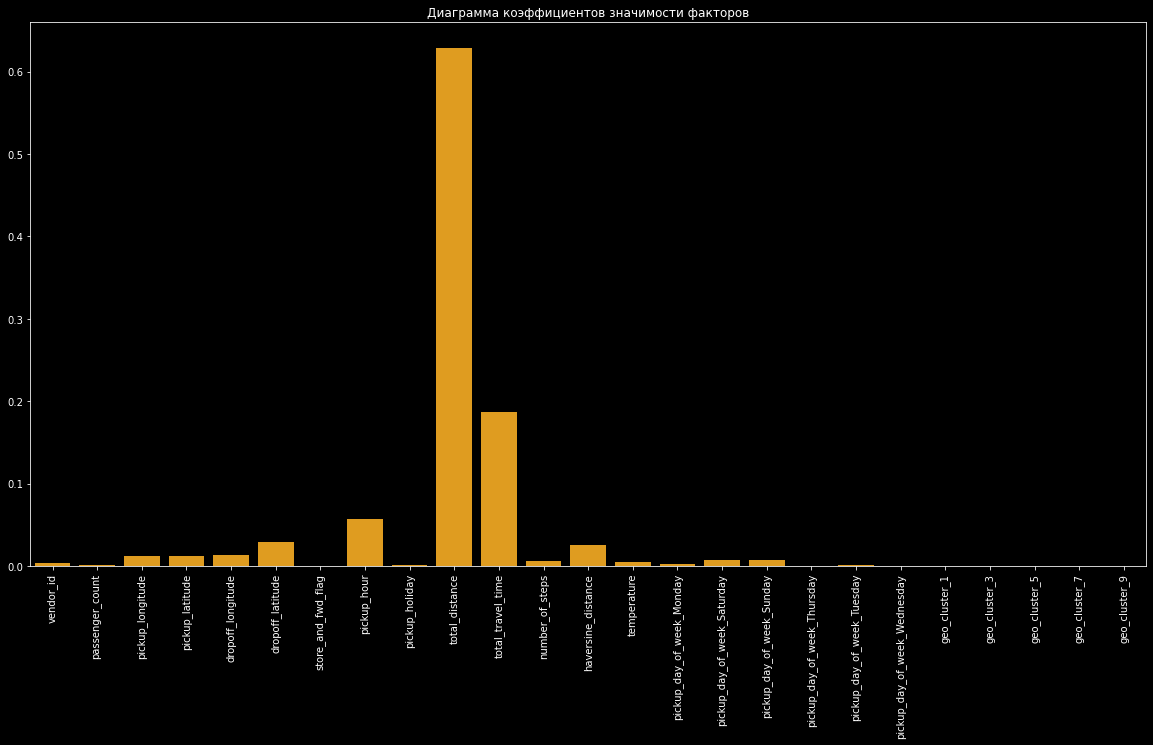

In [144]:
coef = grad_boost.feature_importances_
data = pd.DataFrame([coef], columns=best_features)
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=data,color="orange")
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 90);

### Построенные моделей рассчитайте MeAE
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [146]:
y_norm = np.exp(y_valid_log)-1
y_norm_pred = np.exp(y_valid_log_pred)-1
from sklearn.metrics import median_absolute_error
MeAE = metrics.median_absolute_error(y_norm, y_norm_pred)/60
print(f'медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: {round(MeAE, 1)}')

медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [147]:
test_data = pd.read_csv("/kaggle/input/ny-dataset/test.csv")
osrm_data_test = pd.read_csv("/kaggle/input/nyfastestroutes/fastest_routes_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [148]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

one_hot_encoder = preprocessing.OneHotEncoder(drop='first')
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [149]:
y_test_log_pred = grad_boost.predict(X_test_scaled)
y_test_predict = np.exp(y_test_log_pred)-1

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [150]:
# from IPython.display import FileLink
# FileLink('submission.csv')
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

### XGBoost

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [151]:
!pip install xgboost

После чего модуль можно импортировать:

In [153]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [154]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [155]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93560	valid-rmse:1.93557
[20]	train-rmse:0.78534	valid-rmse:0.78621
[30]	train-rmse:0.47969	valid-rmse:0.48174
[40]	train-rmse:0.42144	valid-rmse:0.42410
[50]	train-rmse:0.40944	valid-rmse:0.41261
[60]	train-rmse:0.40508	valid-rmse:0.40873
[70]	train-rmse:0.40186	valid-rmse:0.40586
[80]	train-rmse:0.40010	valid-rmse:0.40439
[90]	train-rmse:0.39791	valid-rmse:0.40244
[100]	train-rmse:0.39661	valid-rmse:0.40137
[110]	train-rmse:0.39506	valid-rmse:0.40005
[120]	train-rmse:0.39402	valid-rmse:0.39932
[130]	train-rmse:0.39287	valid-rmse:0.39843
[140]	train-rmse:0.39153	valid-rmse:0.39743
[150]	train-rmse:0.39027	valid-rmse:0.39651
[160]	train-rmse:0.38921	valid-rmse:0.39578
[170]	train-rmse:0.38833	valid-rmse:0.39516
[180]	train-rmse:0.38752	valid-rmse:0.39472
[190]	train-rmse:0.38690	valid-rmse:0.39453
[200]	train-rmse:0.38605	valid-rmse:0.39389
[210]	train-rmse:0.38527	valid-rmse:0.39351
[220]	train-rmse:0.38473	valid-rmse:0.39329

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [156]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39133


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

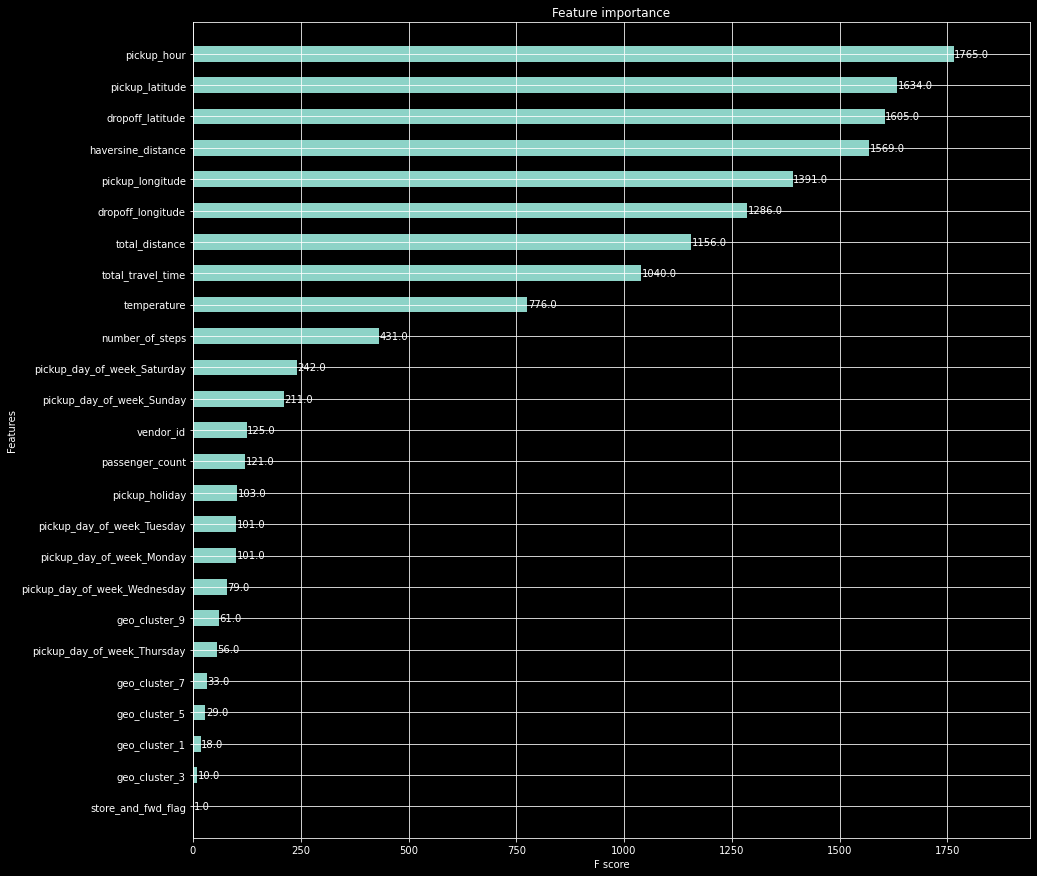

In [157]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)